In [1]:
%matplotlib notebook
# Imports
from data_handler import load_data, DataPlotter

typing_df, gesture_df, layout_df, participants = load_data()


<IPython.core.display.Javascript object>


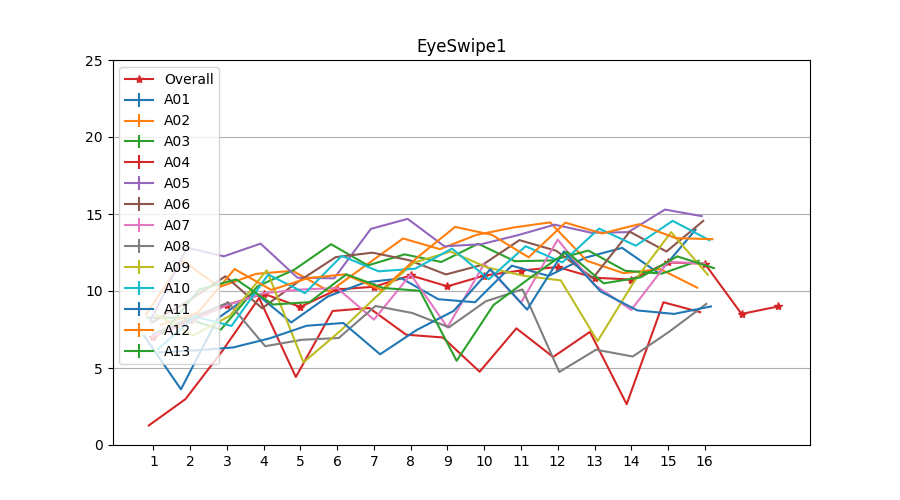

<IPython.core.display.Javascript object>


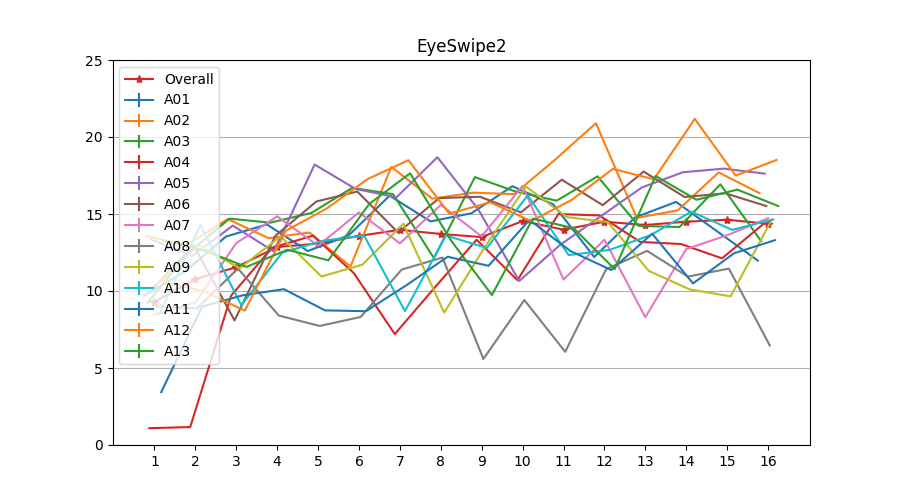

In [2]:
DataPlotter('wpm', typing_df, participants).show(ylim=(0, 25))

<IPython.core.display.Javascript object>


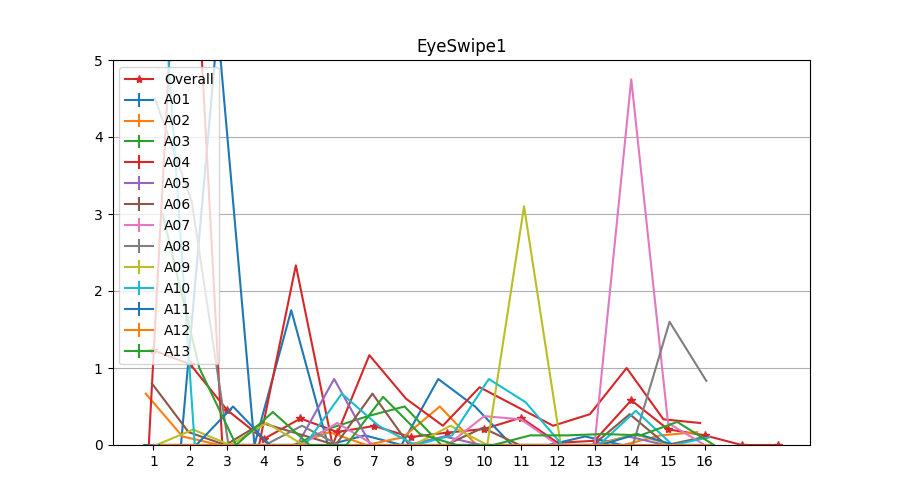

<IPython.core.display.Javascript object>


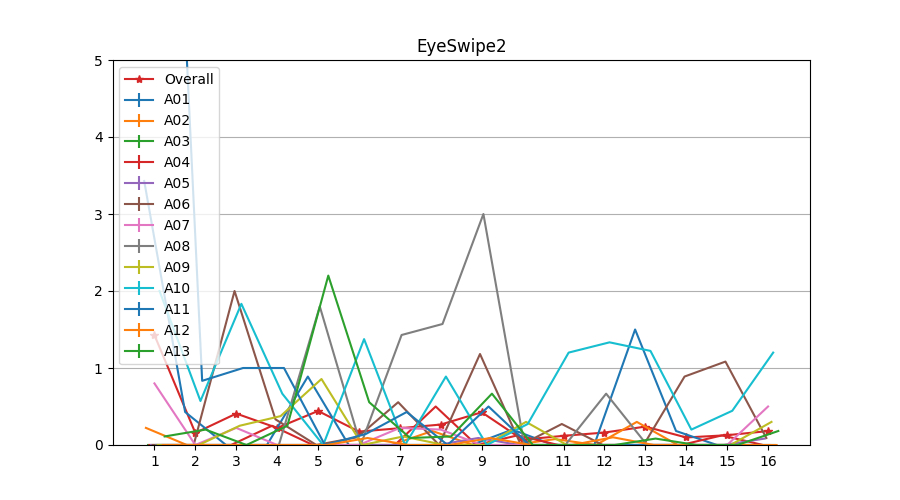

In [3]:
DataPlotter('msd', typing_df, participants).show(ylim=(0, 5))

<IPython.core.display.Javascript object>


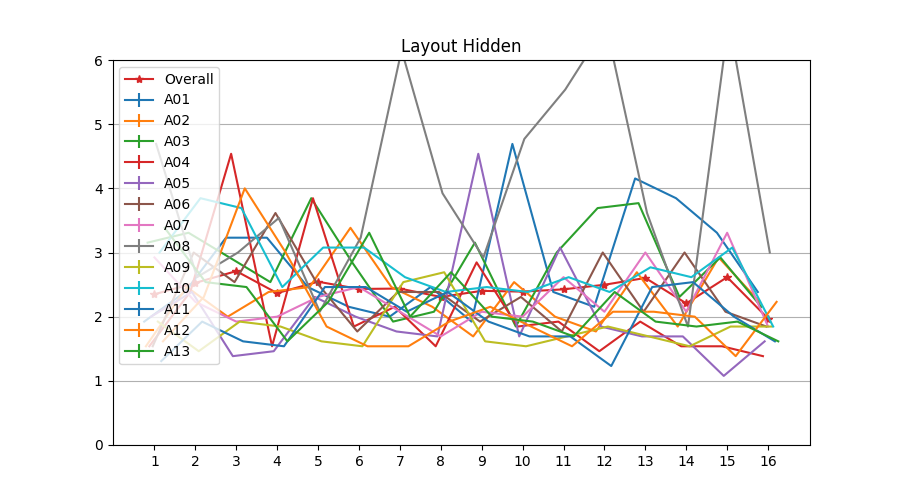

<IPython.core.display.Javascript object>


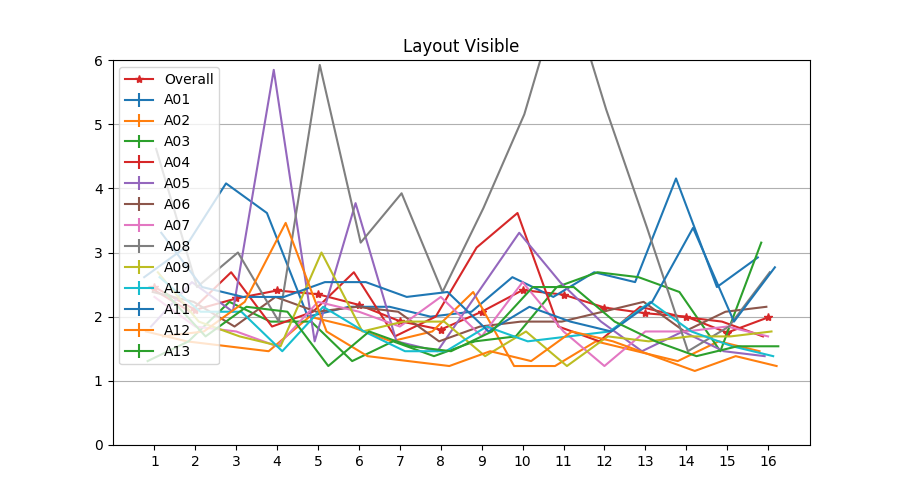

In [4]:
DataPlotter('selection_count', layout_df, participants).show(ylim=(0, 6))

<IPython.core.display.Javascript object>


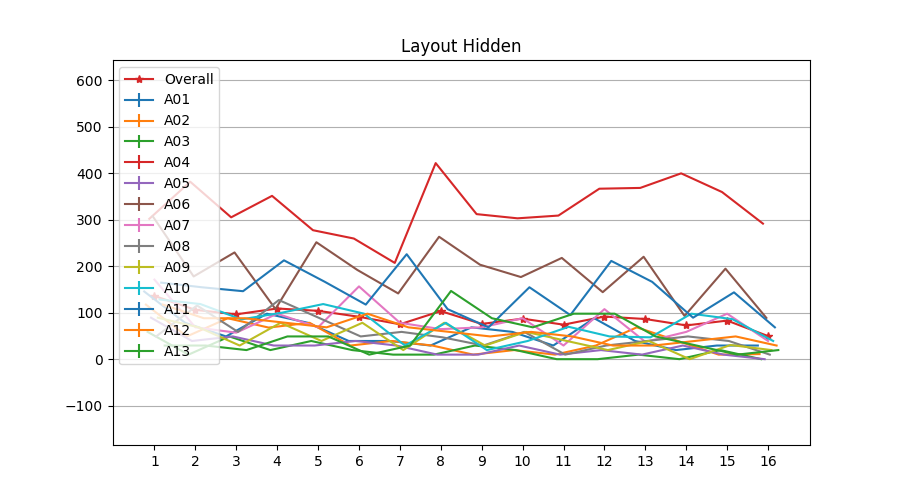

<IPython.core.display.Javascript object>


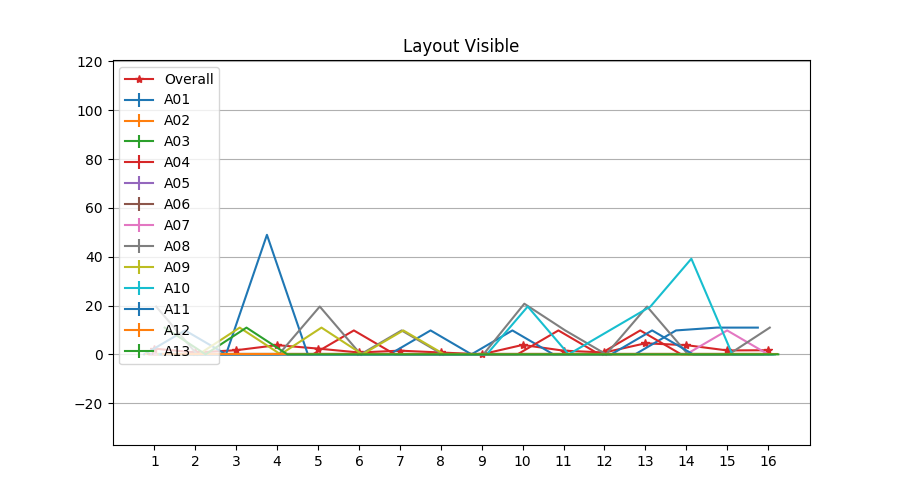

In [5]:
DataPlotter('distance_to_target', layout_df, participants).show()